# Microstate analysis of The Virtual Brain (TVB) data

In [1]:
import mne
from utils import *
#%matplotlib qt

1. Load EEG data exported from TVB simulator. This could be processed in Python directly but we will export as .fif file (MNE compatible), and optionally, as a .set file (EEGLAB compatible).

- The code below works on the unzipped data.
- It's generally no problem to work on the zip file but you need the most current h5py packages, so I show the code for the unzipped hdf files.

## Export TVB exported HDF file
- prepare MNE processing
- MATLAB/EEGLAB option also available

In [2]:
eeg_dir = "./data" # this should be a folder with a single EEG simulation
export_tvb(target=eeg_dir, mne_fmt=True, eeglab_fmt=False)


[+] Loading EEG and sensor data from: ./data
Your h5py version is (should be 2.9 or higher):  3.1.0
Analyzing folder: ./data
Unzipped EEG file: TimeSeriesEEG_8eaabc32aa8d4efca5dfa0d556356957.h5
Unzipped sensor file: Sensors_7b6b6060dde04990b1f79698fe2681c8.h5
Data (squeezed):  (92160, 63)
Time stamps:  (92160,)
Found n=63 EEG channels.
Mapping to standard 10-05 2D coordinates (n=345)
All EEG channels successfully mapped
TVB sampling interval dt = {dt:.4f} ms
Calculated sampling rate fs = 1024.00 Hz
data stats 2:  -4.9999999999999996e-05 4.9999999999999996e-05
Saved as MNE file: TimeSeriesEEG_8eaabc32aa8d4efca5dfa0d556356957_raw.fif


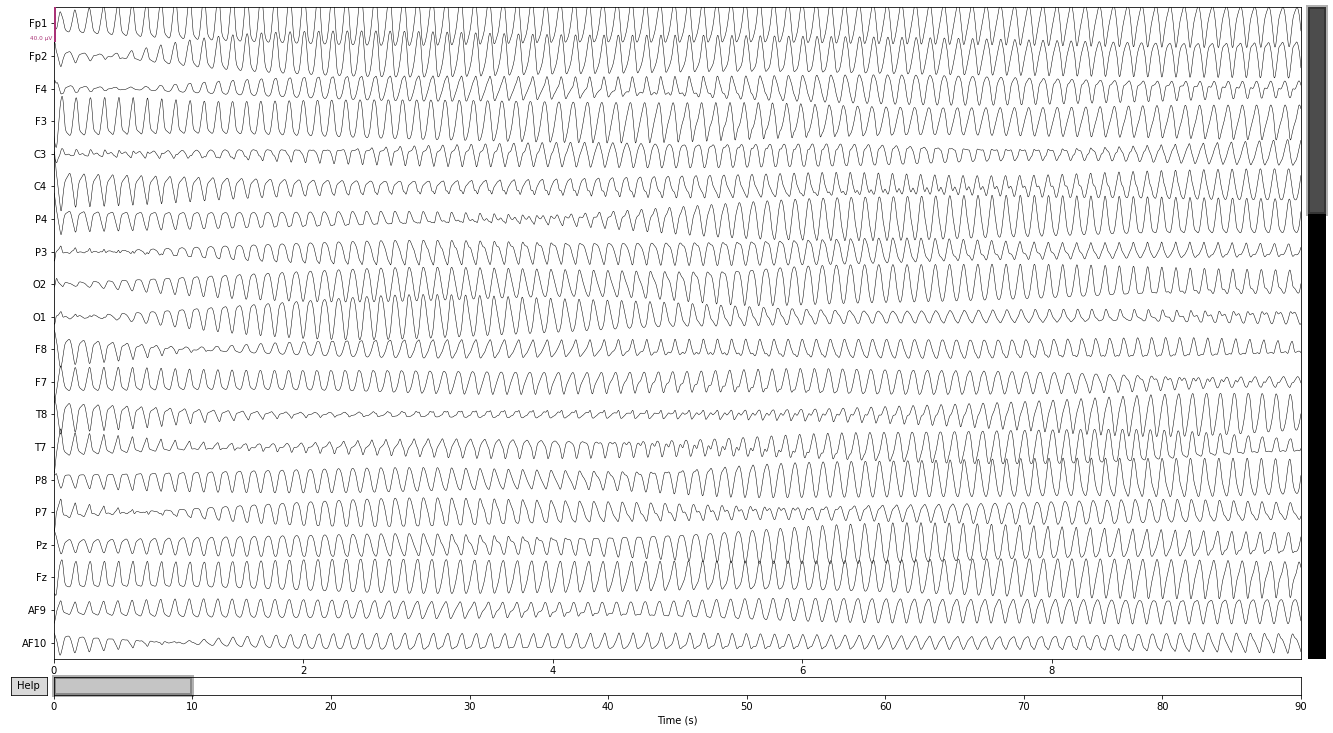

In [4]:
f = "./data/TimeSeriesEEG_8eaabc32aa8d4efca5dfa0d556356957_raw.fif"
raw = mne.io.read_raw(f, preload=True, verbose=False)
_ = raw.plot()

## Microstate analysis

### Band-pass filter and downsample EEG

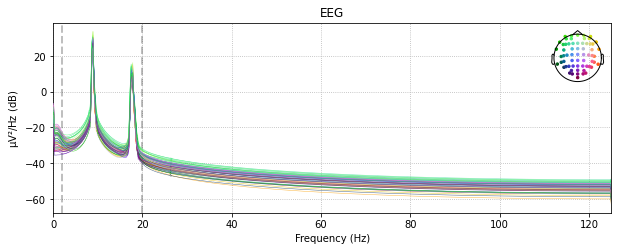

In [5]:
locs = np.load(f"{eeg_dir:s}/chan_locs.npy")
raw = raw.filter(l_freq=2, h_freq=20, verbose=False)
raw = raw.copy().resample(sfreq=250, verbose=False)
_ = raw.plot_psd()

### GFP peaks

In [6]:
fs = raw.info['sfreq']
data = raw.get_data().T
print("Data: ", data.shape)
gfp = np.std(data, axis=1)
gfp_peaks = locmax(gfp)
n_gfp_peaks = len(gfp_peaks)
print(f"Found: {n_gfp_peaks:d} GFP peaks")
n_t = data.shape[0]
times = np.arange(n_t)*1000/raw.info['sfreq'] # time axis in msec

plot_gfp = not True
if plot_gfp:
    plt.figure(figsize=(15,3))
    plt.plot(times, gfp, '-k')
    plt.plot(times[gfp_peaks], gfp[gfp_peaks], 'or', mfc='none')
    plt.xlabel("time (ms)")
    plt.ylabel("GFP")
    plt.tight_layout()
    plt.show()

Data:  (22500, 63)
Found: 1711 GFP peaks


### Modified K-means clustering

	K-means run 1/10 converged after 13 iterations.
	K-means run 2/10 converged after 8 iterations.
	K-means run 3/10 converged after 10 iterations.
	K-means run 4/10 converged after 9 iterations.
	K-means run 5/10 converged after 16 iterations.
	K-means run 6/10 converged after 12 iterations.
	K-means run 7/10 converged after 8 iterations.
	K-means run 8/10 converged after 7 iterations.
	K-means run 9/10 converged after 16 iterations.
	K-means run 10/10 converged after 6 iterations.


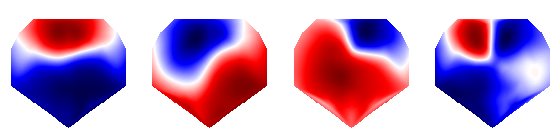

In [7]:
K = 4
data_clustering = data[gfp_peaks,:]
maps = kmeans(data_clustering, n_maps=K)

fig, ax = plt.subplots(1, K, figsize=(2*K, 2))
for i in range(K):
    ax[i].imshow(eeg2map(maps[i,:], locs), origin='lower', cmap=plt.cm.seismic)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

### Back-fitting

Microstate sequence (L) properties:  <class 'numpy.ndarray'> (22500,) int64
Microstate sequence snippet:  [3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1]


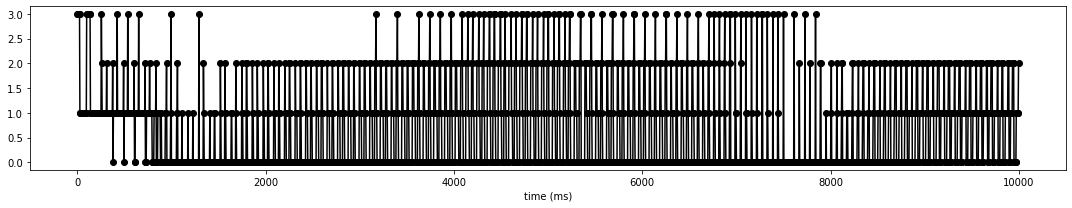

In [8]:
L = backfit(data, maps, smooth='none')
print("Microstate sequence (L) properties: ", type(L), L.shape, L.dtype)
print("Microstate sequence snippet: ", L[:100])

plt.figure(figsize=(15,3))
n_max = 2500
plt.plot(times[:n_max], L[:n_max], '-ok')
plt.xlabel("time (ms)")
plt.tight_layout()
plt.show()

### Microstate statistics

In [9]:
dur_dict, occ, cov = ms_stats(L, fs)
for k in range(K):
    print(f"\nms-{k:d}")
    print(f"Mean duration: {np.mean(dur_dict[k]):.2f} ms")
    print(f"Occurrence: {occ[k]:.2f}/s")
    print(f"Coverage: {cov[k]:.2f}")


ms-0
Mean duration: 19.89 ms
Occurrence: 15.20/s
Coverage: 0.30

ms-1
Mean duration: 20.25 ms
Occurrence: 12.09/s
Coverage: 0.24

ms-2
Mean duration: 18.61 ms
Occurrence: 14.28/s
Coverage: 0.27

ms-3
Mean duration: 16.93 ms
Occurrence: 11.06/s
Coverage: 0.19
